In [20]:
import numpy as np
import plotly
import pandas as pd
import plotly.express as px
from sklearn.pipeline import FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [21]:
recipes = pd.read_csv("/Users/Owner/Downloads/recipes/RAW_recipes.csv")
interactions = pd.read_csv("/Users/Owner/Downloads/recipes/RAW_interactions.csv")

In [22]:
display(recipes.head(3))
display(interactions.head(3))

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...


In [23]:
print(recipes.columns)
print(interactions.columns)

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')
Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')


In [24]:
print(recipes.isna().any())
print(interactions.isna().any())


name               True
id                False
minutes           False
contributor_id    False
submitted         False
tags              False
nutrition         False
n_steps           False
steps             False
description        True
ingredients       False
n_ingredients     False
dtype: bool
user_id      False
recipe_id    False
date         False
rating       False
review        True
dtype: bool


In [25]:

print(recipes['nutrition'][1])


[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]


In [26]:
merged_df = pd.merge(recipes, interactions, left_on = 'id', right_on = 'recipe_id', how = 'left')
len(merged_df)

1132367

In [27]:
# Replace ratings of 0 to np.nan
merged_df.replace(0, np.nan, inplace = True)

In [28]:
avg_rating_per_recipe = merged_df.groupby('recipe_id')['rating'].mean()
display(avg_rating_per_recipe)

recipe_id
38        4.250000
39        3.000000
40        4.333333
41        4.500000
43        1.000000
            ...   
537459    5.000000
537485    5.000000
537543         NaN
537671         NaN
537716    5.000000
Name: rating, Length: 231637, dtype: float64

In [29]:
avg_rating_df = pd.DataFrame(avg_rating_per_recipe)
avg_rating_df.rename(columns = {'rating': 'avg_rating'}, inplace = True)
merged_df2 = pd.merge(merged_df, avg_rating_df, on = 'recipe_id')
merged_df2.head()
# Ratings of 0 stars indicate reviews with no star ratings. (gave it a review without giving it a rating)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,user_id,recipe_id,date,rating,review,avg_rating
0,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11.0,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,4470,137739,2006-02-18,5.0,I used an acorn squash and recipe#137681 Swee...,5.000000
1,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11.0,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,593927,137739,2010-08-21,5.0,This was a nice change. I used butternut squas...,5.000000
2,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11.0,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,178427,137739,2011-12-05,5.0,Excellent recipe! I used butternut squash and ...,5.000000
3,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9.0,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,28603,31490,2002-08-19,NaN,"Have not tried this, but it sounds delicious. ...",4.666667
4,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9.0,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,346277,31490,2006-08-27,5.0,This recipe was wonderful. Instead of using t...,4.666667


In [30]:
# Change column nutrition to calories, total fat, sugar, sodium, protein, saturated fat, carbohydrates
import re
# convert a string resembling a list of floats into an actual list of floats (for nutrition column)
def string_to_float_list(s):
    return [float(i) for i in re.findall('\d+\.\d', s)]

# convert a string resembling a list of strings into a list of strings (for tags and steps columns)
def string_to_string_list(s):
    return re.findall('\'(.+?)\'', s)

# apply string to float list to "nutrition", "steps", "tags"
merged = merged_df2.copy()
merged['nutrition'] = merged['nutrition'].apply(string_to_float_list)
merged['steps'] = merged['steps'].apply(string_to_string_list)
merged['tags'] = merged['tags'].apply(string_to_string_list)


In [31]:

merged = merged.assign(**{
    'calories (#)' : merged['nutrition'].str[0],
    'total fat (PDV)' : merged['nutrition'].str[1],
    'sugar (PDV)' : merged['nutrition'].str[2],
    'sodium (PDV)' : merged['nutrition'].str[3],
    'protein (PDV)' : merged['nutrition'].str[4],
    'saturated fat (PDV)' : merged['nutrition'].str[5],
    'carbohydrates (PDV)' : merged['nutrition'].str[6],
    })


In [32]:
merged.head(5)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,rating,review,avg_rating,calories (#),total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11.0,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,...,5.0,I used an acorn squash and recipe#137681 Swee...,5.000000,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11.0,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,...,5.0,This was a nice change. I used butternut squas...,5.000000,51.5,0.0,13.0,0.0,2.0,0.0,4.0
2,arriba baked winter squash mexican style,137739,55.0,47892,2005-09-16,"[60-minutes-or-less, time-to-make, course, mai...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11.0,"[make a choice and proceed with recipe, depend...",autumn is my favorite time of year to cook! th...,...,5.0,Excellent recipe! I used butternut squash and ...,5.000000,51.5,0.0,13.0,0.0,2.0,0.0,4.0
3,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9.0,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,...,NaN,"Have not tried this, but it sounds delicious. ...",4.666667,173.4,18.0,0.0,17.0,22.0,35.0,1.0
4,a bit different breakfast pizza,31490,30.0,26278,2002-06-17,"[30-minutes-or-less, time-to-make, course, mai...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9.0,"[preheat oven to 425 degrees f, press dough in...",this recipe calls for the crust to be prebaked...,...,5.0,This recipe was wonderful. Instead of using t...,4.666667,173.4,18.0,0.0,17.0,22.0,35.0,1.0


In [34]:
# Cleaned preprocessing and train-test split
merged_copy = merged.dropna(subset=['calories (#)', 'minutes', 'avg_rating', 'tags']).copy()  # Drop NaNs + make a copy
merged_copy['tags'] = merged_copy['tags'].apply(lambda x: ' '.join(x))  # Convert tag list to string

# Perform proper train-test split
X = merged_copy.drop('avg_rating', axis=1)
y = merged_copy['avg_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=214)


In [35]:
# make baseline model
def create_baseline_model(X_train, y_train): # Concatenating average
    # transform numerical columns
    log_transformer = FunctionTransformer(lambda x: np.log1p(x))
    
    preprocessing = make_column_transformer(
        (log_transformer, ['calories (#)', 'minutes']),  # Apply log transformation to 'calories' and 'minutes'
        remainder='drop'  # Drop other columns not being used
    )
        
    # The pipeline
    model = make_pipeline(preprocessing, LinearRegression()) # apply l1 regularization
    
    # Define feature columns
    feature_cols = ['calories (#)', 'minutes']
    return model.fit(X_train[feature_cols], y_train)

baseline_model = create_baseline_model(X_train, y_train)

baseline_model.predict(pd.DataFrame([{
    'calories (#)': 1, # slight positive coefficient, more caloric recipes more favorable
    'minutes': 8000000 # slight negative coefficient, longer recipes less favorable
}]))[0]

np.float64(4.468319652990231)

In [73]:
# make experimental model (Vector of vector spaces, each index is a date, manipulate so its reflective of time series)
def create_experimental_model(X_train, y_train): # For average rating, we concatenate all tags into a large string, and then use that string to predict avg rating. Avg calories and minutes
    # transform numerical columns
    log_transformer = FunctionTransformer(lambda x: np.log1p(x))
    
    # Fat ratio function transformer
    fat_ratio_transformer = FunctionTransformer(
        lambda X: ((X['saturated fat (PDV)'] / X['total fat (PDV)']).where(X['total fat (PDV)'] != 0, 0)).to_frame(name='fat_ratio')
    )

    # Pipeline to process the ratio: transformer + scaler
    fat_ratio_pipeline = make_pipeline(
        fat_ratio_transformer,
        StandardScaler()
    )

    preprocessing = make_column_transformer(
        (log_transformer, ['calories (#)', 'minutes']),  # Apply log transformation to 'calories' and 'minutes'
        (TfidfVectorizer(), 'tags'),  # Apply TF-IDF vectorization to 'tags'
        (fat_ratio_pipeline, ['saturated fat (PDV)', 'total fat (PDV)']),
        remainder='drop'  # Drop other columns not being used
    )
        
    # The pipeline
    # model = make_pipeline(preprocessing, Lasso()) # apply l1 regularization
    param_grid = {'lasso__alpha': [0.00005, 0.0001, 0.001, 0.01, 0.1]}

    grid_search = GridSearchCV(
        make_pipeline(preprocessing, Lasso()),
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1  # Need this bc the model with only 1 cpu at a time is super slow to run grid search
    )
    
    # Define feature columns
    feature_cols = ['calories (#)', 'minutes', 'tags', 'saturated fat (PDV)', 'total fat (PDV)']
    return grid_search.fit(X_train[feature_cols], y_train)

experimental_model = create_experimental_model(X_train, y_train)

experimental_model.predict(pd.DataFrame([{
    'calories (#)': 10,
    'minutes': 70000,
    'tags': '60-minutes-or-less chicken-stew', # FOR NOW MUST BE A STRING NOT A LIST
    'saturated fat (PDV)': 100, 
    'total fat (PDV)': 100
}]))[0]

np.float64(4.613479062624028)

In [66]:
# ON ALL TEST DATA UNCONDITIONAL OF GROUPING BY MSE OF AVG RATINGS
baseline_predictions = baseline_model.predict(X_test)
experimental_predictions = experimental_model.predict(X_test)
baseline_mse = mean_squared_error(y_test, baseline_predictions)
experimental_mse = mean_squared_error(y_test, experimental_predictions)

# printing mse on test
print("Baseline MSE:", baseline_mse)
print("Experimental MSE:", experimental_mse)

Baseline MSE: 0.1624692189447188
Experimental MSE: 0.15743681246313235


In [74]:
# On test data with two mean squared error estimates (mse of avg_rating > 4 and avg_rating < 4)
high_ratings = y_test > 4
low_ratings = y_test <= 4
baseline_hr_predictions = baseline_model.predict(X_test[high_ratings])
experimental_hr_predictions = experimental_model.predict(X_test[high_ratings])
baseline_lr_predictions = baseline_model.predict(X_test[low_ratings])
experimental_lr_predictions = experimental_model.predict(X_test[low_ratings])

baseline_hr_mse = mean_squared_error(y_test[high_ratings], baseline_hr_predictions)
experimental_hr_mse = mean_squared_error(y_test[high_ratings], experimental_hr_predictions)
baseline_lr_mse = mean_squared_error(y_test[low_ratings], baseline_lr_predictions)
experimental_lr_mse = mean_squared_error(y_test[low_ratings], experimental_lr_predictions)

print("Baseline MSE (avg_rating > 4):", baseline_hr_mse)
print("Baseline MSE (avg_rating ≤ 4):", baseline_lr_mse)
print("Experimental MSE (avg_rating > 4):", experimental_hr_mse)
print("Experimental MSE (avg_rating ≤ 4):", experimental_lr_mse)

Baseline MSE (avg_rating > 4): 0.05643971271744867
Baseline MSE (avg_rating ≤ 4): 1.3064108322887997
Experimental MSE (avg_rating > 4): 0.053527898968461524
Experimental MSE (avg_rating ≤ 4): 1.2746447959871094


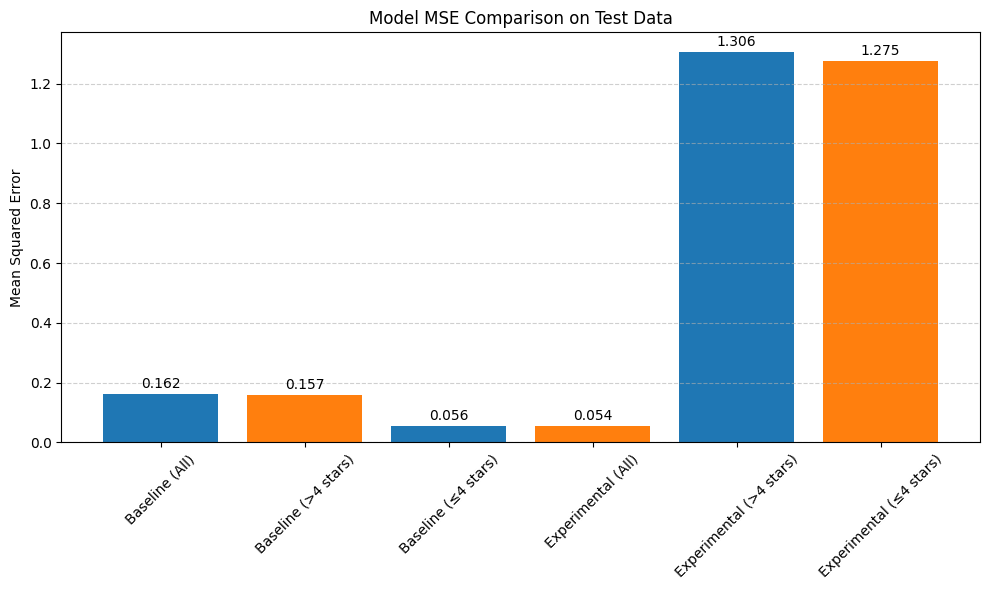

In [75]:
# Labels and values
labels = [
    "Baseline (All)",
    "Baseline (>4 stars)",
    "Baseline (≤4 stars)",
    "Experimental (All)",
    "Experimental (>4 stars)",
    "Experimental (≤4 stars)"
]

mse_values = [
    baseline_mse,
    experimental_mse,
    baseline_hr_mse,
    experimental_hr_mse,
    baseline_lr_mse,
    experimental_lr_mse
]
# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, mse_values, color=['#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e', '#1f77b4', '#ff7f0e'])

# Annotate bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylabel("Mean Squared Error")
plt.title("Model MSE Comparison on Test Data")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

In [76]:
print("Best alpha:", experimental_model.best_params_['lasso__alpha']) # best alpha is 7.5 e-05
# ITS ALWAYS THE SMALLEST WHICH IS INTERESTING


Best alpha: 5e-05


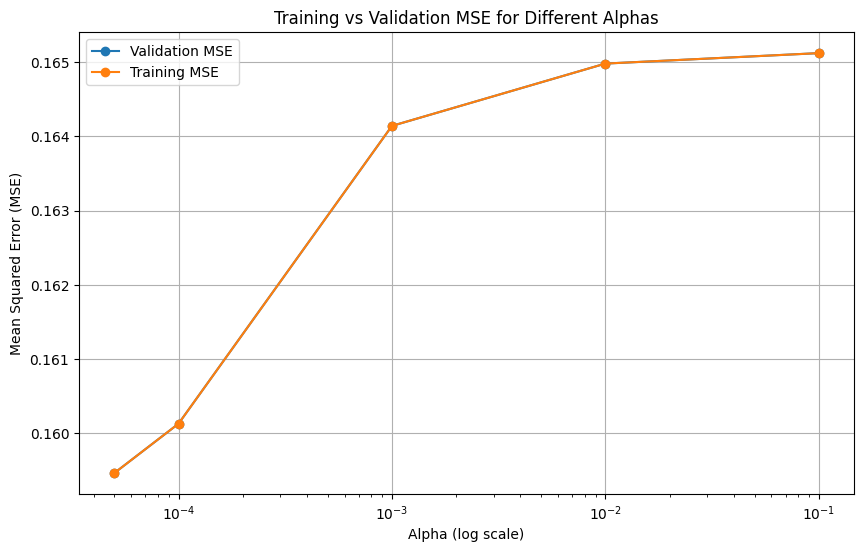

In [77]:
results = experimental_model.cv_results_
# print(results.keys())
# Extracting the alphas, and the validation MSE
alphas = results['param_lasso__alpha']
val_mse = results['mean_test_score']

# Set to negative of mean to reflect actual MSE
train_mse = -np.mean([results[f'split{i}_test_score'] for i in range(5)], axis=0)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(alphas, -val_mse, label='Validation MSE', marker='o')
plt.plot(alphas, train_mse, label='Training MSE', marker='o')
plt.xscale('log')  # Using log scale for alpha values
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Validation MSE for Different Alphas')
plt.legend()
plt.grid(True)
plt.show()
